In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import numpy as np
import torch

from tqdm import tqdm
from scipy import stats

from src.utils import ratemap_collage, weighted_kde, SimpleDatasetMaker
from src.models import RecurrentSpaceNet, Decoder, End2End

plt.style.use("figures/project_style.mplstyle")

In [2]:
save_loc = "figures" # location for saving figures

In [3]:
## Training parameters
train_steps = 10000
timesteps = 10
bs = 64 # batch size

# Model parameters
n_in = 2 # Cartesian coordinates, no context
n_out = 100 # no. of spatial representations

In [4]:
# instantiate RNN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RecurrentSpaceNet(n_in = n_in, n_out = n_out, corr_across_space= True, device = device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

/home/m/miniconda3/envs/ml/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
genny = SimpleDatasetMaker() # use simple dataset

In [6]:
train_history = []
progress = tqdm(range(train_steps))
for i in progress: # train loop
    r, v = genny.generate_dataset(bs, timesteps, device = device)
    r_label = r[:,1:]
    loss = model.train_step(x = (v, r[:,0]), y = r_label, optimizer = optimizer)

    if i % 10 == 0:
        train_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.004897:  10%|▉         | 977/10000 [00:22<03:31, 42.67it/s]


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(4,4))
plt.semilogy(np.arange(len(train_history))*10, train_history, "-k")
plt.xlabel("Train Step")
plt.ylabel("Train Loss")
plt.savefig(f"{save_loc}/model_loss_history")

In [7]:
decoder = Decoder(n_in = n_out, n_out = 2) # train decoder
optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-4)

In [8]:
decoder_history = []

progress = tqdm(range(train_steps))
for i in progress: # train loop
    r, v = genny.generate_dataset(bs, timesteps, device = device)

    # Train decoder on data from RNN model 
    p = model.spatial_representation(v, model.p0(r[:,0])[None])[0].detach()
    p = p.detach() 
    p = torch.reshape(p, (-1, p.shape[-1]))
    r_label = r[:,1:].reshape(-1, 2)
    # labels are just Cartesian coordinates
    loss = decoder.train_step(x = p, y = r_label, optimizer = optimizer)

    if i % 10 == 0:
        decoder_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.000914:  21%|██        | 2060/10000 [00:12<00:46, 171.31it/s]


KeyboardInterrupt: 

In [ ]:
# plot loss histories for comparable models
plt.figure(figsize = (4, 4))
plt.semilogy(np.arange(len(decoder_history))*10, decoder_history)
plt.xlabel("Train Step")
plt.ylabel("Decoder MSE")
plt.savefig(f"{save_loc}/comparison_loss_history")

In [9]:
# evaluate both model to visualize prediction error
n_eval = 5000
r, v = genny.generate_dataset(n_eval, timesteps, device = device)

# e2e_pred = end_to_end((v, r[:,0])).detach().numpy()
# error = np.linalg.norm(e2e_pred - r[:,1:].detach().numpy(), axis = -1)
# e2e_error = error.reshape(n_eval, timesteps-1)

p = model.spatial_representation(v, model.p0(r[:,0])[None])[0].detach()
decoder_pred = decoder(p).detach().numpy()
decoder_error = np.linalg.norm(decoder_pred - r[:,1:].detach().numpy(), axis = -1)
decoder_error = decoder_error.reshape(n_eval, timesteps - 1)

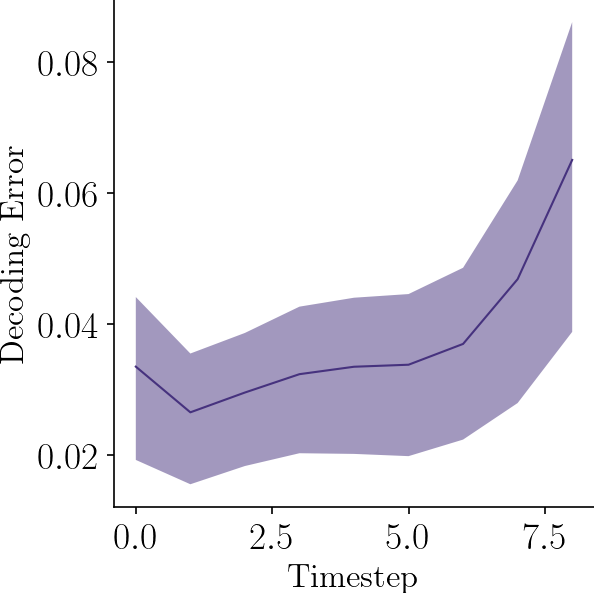

In [10]:
plt.figure(figsize=(4,4))
#e2e_quartiles = np.percentile(e2e_error, [25, 75], axis = 0)
decoder_quartiles = np.percentile(decoder_error, [25, 75], axis = 0)

#plt.plot(np.mean(e2e_error, axis = 0), label = "End to End")
#plt.fill_between(np.arange(timesteps - 1), e2e_quartiles[0], e2e_quartiles[1], alpha = 0.5)
plt.plot(np.mean(decoder_error, axis = 0), label = "Decoder")
plt.fill_between(np.arange(timesteps - 1), decoder_quartiles[0], decoder_quartiles[1], alpha = 0.5)
plt.xlabel("Timestep")
plt.ylabel("Decoding Error")
#plt.legend()
plt.savefig(f"{save_loc}/decoding_error")

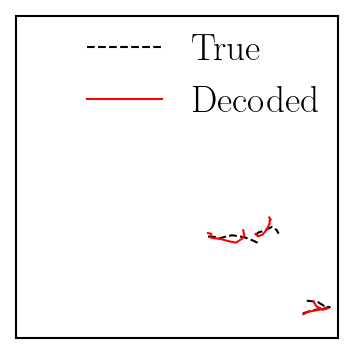

In [11]:
fig, ax = plt.subplots(1)
def draw_square(ax):
    square = np.array([[[-1, -1], [1, -1]], [[1, -1], [1,1]], 
                        [[1, 1], [-1,1]], [[-1, 1], [-1,-1]]])
    for segment in square:
        ax.plot(*segment, "k")
        
for i in range(3):
    pass
    ax.plot(*r[i].T, "k--")
    ax.plot(*decoder_pred[i].T, "r")

plt.legend(["True", "Decoded"])
draw_square(ax)
ax.set_aspect("equal")
ax.axis([-1.1, 1.1, -1.1, 1.1])
ax.axis("off")
plt.savefig(f"{save_loc}/decoded_trajectory")

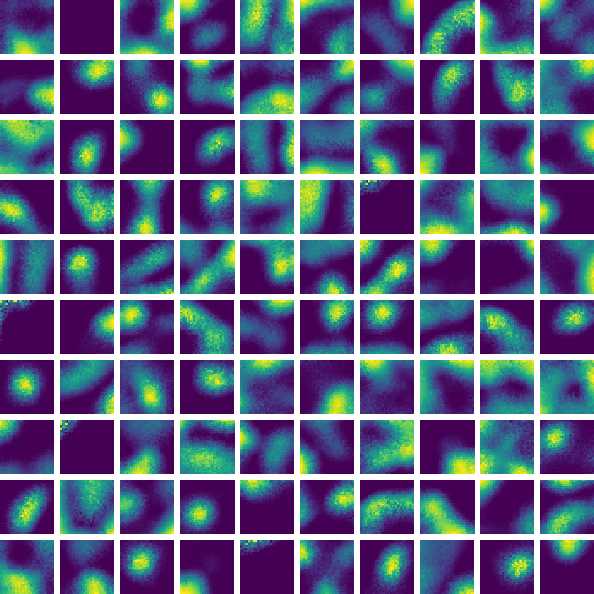

In [12]:
# visualize representations
n_plot = 5000 # number of plot trajectories
n_show = 100 # number of units to show
r, v = genny.generate_dataset(n_plot, timesteps)

# BSR 
p,_ = model.spatial_representation(v, model.p0(r[:,0])[None])
p = p.detach().numpy()
ps = p.reshape(-1, p.shape[-1])
rs = r[:,1:].detach().numpy().reshape(-1, 2)
ratemaps, _, _, _ = stats.binned_statistic_2d(rs[:,0], rs[:,1],ps.T, bins = 32)
fig, ax = ratemap_collage(ratemaps[:n_show], cols = int(np.sqrt(n_show)), figsize = (4,4))
plt.savefig(f"{save_loc}/rnn_representations")

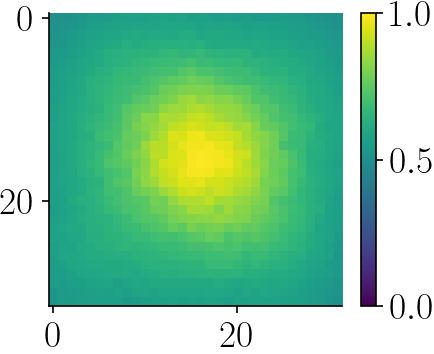

In [13]:
sim = np.exp(-np.sum((ratemaps[:,16,16,None,None] - ratemaps)**2, axis = 0))
plt.imshow(sim.reshape(32,32), interpolation = "None", vmin = 0)
plt.colorbar()